<a href="https://colab.research.google.com/github/Yuvasri1901/TNSDC---generative-ai/blob/main/InteriorD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'interior-design:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817307%2F1399134%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T163517Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9441acf87e9131bce8806da473d4c112a1466036d703a557942619c4cf1d5c2e7d5e6805aa69ed6b09bc09bb84ed09e54a47b322da56d4651cd468b702a0b6a13c5472574000390f86b0717cd8448b3a638ea7b410e76eff95977c7b21a0723aeb6021e9573a824904bf7c02bcdefb4596ec1b75e82591a53778fb7472f05f5bd5fecaac0c292de99cb117822f9597962c6bb7b6d1479657c1c10805f7955e8f1e97382dc2e09f4a03e9c180b589a8b6f40374bc38aa531e984fc84fff039b166271e4be40d7b6c207c0eb39129e2f8b423a40cd8d9554d9bfe898ea251cd71c765907db42f5dfd1c2e8a628febbd61f7b367bad2e799b2a1757f44f057f0e76'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 141879955 bytes downloaded
Downloaded and uncompressed: interior-design
Data source import complete.


In [2]:
# Libraries Import
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose
from tensorflow.compat.v1.keras.layers import BatchNormalization

# Ignore Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Search List of Images in Directory
def list_images(basePath):
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"))

# Search Files with Image Extensions
def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp")):
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        for filename in filenames:
            ext = filename[filename.rfind("."):].lower()
            if ext.endswith(validExts):
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

#Extract Image Files from the Kaggle Directory
def load_images(directory='', size=(64,64)):
    images = []
    labels = []
    label = 0
    imagePaths = list(list_images(directory))
    for path in imagePaths:
        path = path.replace('\\','/')
        image = cv2.imread(path)
        image = cv2.resize(image,size)
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return images

In [4]:
# Load Images
images=load_images('../input/interior-design')

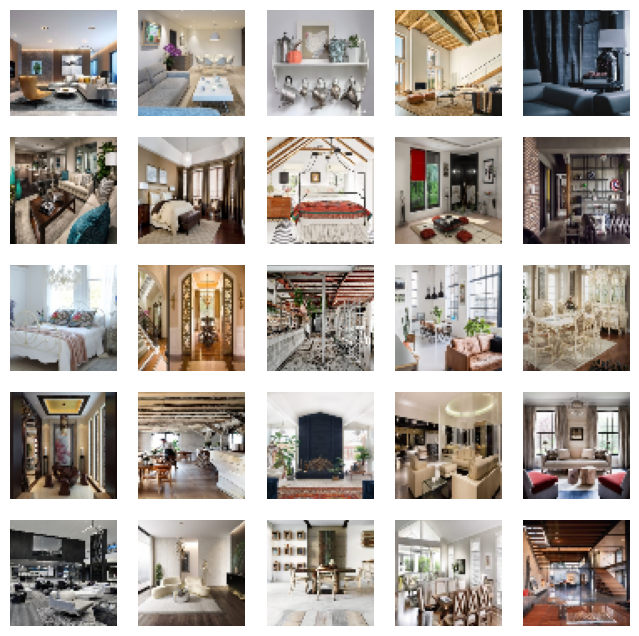

In [5]:
# Check Images by Plotting
_,ax = plt.subplots(5,5, figsize = (8,8))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [9]:
# GAN Model
!pip install tensorflow-gpu
from tensorflow.keras.optimizers import Adam
class GAN():
    # learning rate 0.0002, regularization 0.1
    # noise 100px random, loss binary cross
    # convolutional layer
    def __init__(self):
        self.img_shape = (64, 64, 3)
        self.noise_size = 100
        self.optimizer = Adam(learning_rate=0.0002,beta_1=0.1)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.discriminator.trainable = False
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.summary()

    # Generator Model
    # deconvolutional layer
    # leaky relu with neg slope 0.2
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)

        model = Sequential()
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(Activation("tanh"))

        model.summary()
        noise = Input(shape=noise_shape)
        img = model(noise)
        return Model(noise, img)

    # Discriminator Model
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.4))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        print(validity.shape)
        print(img, validity)
        return Model(img, validity)

    # Training Model
    def train(self, epochs, batch_size=512, metrics_update=50, save_images=100, save_model=2000):
        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        half_batch = int(batch_size / 2)
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))
                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)

            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss

            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0

            # Saving 100 images
            if epoch % save_images == 0:
                self.save_images(epoch)

            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Save Training Images into Desired File
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        fig.savefig("Interior/Rooms_%d.png" % epoch)
        plt.close()

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
# Save Training In Interior Folder
!mkdir Interior

In [11]:
# GAN Training Session
# batch size as [512, 1023]
# epochs as [15000, 20000, 8400]
!pip install tensorflow
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan=GAN()
gan.train(epochs=20001, batch_size=512, metrics_update=100, save_images=1000, save_model=20000)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_12 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_13 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                    

KeyError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_10/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [12]:
# Generate Interior Design Randomly
# Based on Trained Parameter in Generator
# Determine size, batch size, use generator
# to predict, display only 25 of the images

noise_size = 100
half_batch = 25
gan = load_model('/kaggle/input/result/results/generator_15000')
noise = np.random.normal(0, 1, (half_batch, noise_size))
gen_img = gan.predict(noise)
fig, axs = plt.subplots(5,5, figsize = (8,8))
gen_img = 0.5 * gen_img + 0.5

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(gen_img[5*i+j])
        axs[i,j].axis('off')

plt.show()

OSError: No file or directory found at /kaggle/input/result/results/generator_15000